In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Chan 2019-08-12 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.13.1
matplotlib 3.1.0
imblearn 0.5.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle

# Load datasets

In [3]:
datasets = pd.DataFrame()
for i in range(1,9):
    print(i)
    dump = pd.read_csv("../../data/labeled ({}).csv".format(i), engine='python')
    datasets = pd.concat([datasets, dump])
datasets.head()

1
2
3
4
5
6
7
8


,comment,url_id,label
0,ㅜㅜ,77,0
1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,17,0
2,헐,52,0
3,제시,75,0
4,이거인 듯,18,0


In [4]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 0 to 2999
Data columns (total 3 columns):
comment    23999 non-null object
url_id     24000 non-null int64
label      24000 non-null int64
dtypes: int64(2), object(1)
memory usage: 750.0+ KB


In [5]:
datasets.comment.fillna('NULL',inplace=True)

In [6]:
datasets.reset_index(drop=True,inplace=True)

In [7]:
datasets.label = datasets.label.astype('int')

In [8]:
len(datasets[datasets.label ==1])/ len(datasets) # 유해한 레이블의 데이터가 많이 부족함 데이터 편향ㅠㅠ

0.04641666666666667

# Tokenize
## 형태소분석

In [9]:
morp = Okt()

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [10]:
morped = [morp.morphs(_, norm=True, stem=True) for _ in tqdm(datasets.comment)] # Stemming은 하지 않는다.

100%|███████████████████████████████████████████████████████████████████████████| 24000/24000 [01:13<00:00, 327.27it/s]


In [11]:
morped[:5]

[['ㅜㅜ'], ['ㅋㅋㅋ'], ['헐다'], ['제시'], ['이', '거인', '듯']]

## Dictionary
최빈 형태소에 대한 단어사전 구성

In [12]:
vocab_size = 10000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

        vocab = {
        '<PAD>': pad_id,
        '<OOV>': oov_id
        }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(morped)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# vocab save
with open('./vocab/vocab_index.pickle', 'wb') as f:
    pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
    pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
ㅋㅋㅋ :  4524
? :  1825
이 :  1753
하다 :  1353
! :  646
ㅋㅋ :  629
가 :  600
오다 :  543
아 :  500
이다 :  467

단어 사전:
0 <PAD>
1 <OOV>
2 ㅋㅋㅋ
3 ?
4 이
5 하다
6 !
7 ㅋㅋ
8 가
9 오다

단어 사전 크기:  10000


In [13]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", morped[0])
ids = text_to_index(morped[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['ㅜㅜ']
문자 -> 숫자:  [250]
숫자 -> 문자:  ㅜㅜ


# Padding

In [14]:
x_variable = [text_to_index(_) for _ in morped]

sentence_size = 10
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

In [15]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [16]:
import warnings
warnings.filterwarnings(action='once')


# 데이터 클래스 불균형 문제 해결하자

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## upsampling
- 딥러닝은 데이터가 많을수록 좋다.
- 보다 많은 데이터 사용을 위해 upsampling을 사용하자!

In [18]:
up_X, up_y = RandomOverSampler().fit_resample(x_padded, datasets.label)
up_X_train, up_X_test, up_y_train, up_y_test = train_test_split(up_X, up_y)

# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(45772, 22886)

In [19]:
model_up = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 34329 samples, validate on 11443 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5


22048/34329 [==================>...........] - ETA: 2:01:36 - loss: 0.6969 - recall: 0.125 - ETA: 40:49 - loss: 0.6941 - recall: 0.1458  - ETA: 20:30 - loss: 0.6933 - recall: 0.114 - ETA: 15:31 - loss: 0.6939 - recall: 0.113 - ETA: 9:35 - loss: 0.6926 - recall: 0.115 - ETA: 7:51 - loss: 0.6928 - recall: 0.11 - ETA: 7:00 - loss: 0.6924 - recall: 0.12 - ETA: 5:46 - loss: 0.6923 - recall: 0.13 - ETA: 5:33 - loss: 0.6923 - recall: 0.14 - ETA: 5:23 - loss: 0.6923 - recall: 0.14 - ETA: 4:38 - loss: 0.6924 - recall: 0.17 - ETA: 4:04 - loss: 0.6922 - recall: 0.18 - ETA: 3:58 - loss: 0.6920 - recall: 0.19 - ETA: 3:46 - loss: 0.6921 - recall: 0.19 - ETA: 3:23 - loss: 0.6922 - recall: 0.19 - ETA: 3:01 - loss: 0.6920 - recall: 0.22 - ETA: 2:50 - loss: 0.6919 - recall: 0.23 - ETA: 2:44 - loss: 0.6921 - recall: 0.23 - ETA: 2:36 - loss: 0.6921 - recall: 0.23 - ETA: 2:23 - loss: 0.6919 - recall: 0.25 - ETA: 2:14 - loss: 0.6918 - recall: 0.27 - ETA: 2:06 - loss: 0.6916 - recall: 0.28 - ETA: 2:01 - loss

34329/34329 [==============================] - ETA: 10s - loss: 0.4569 - recall: 0.756 - ETA: 10s - loss: 0.4557 - recall: 0.758 - ETA: 10s - loss: 0.4543 - recall: 0.759 - ETA: 10s - loss: 0.4535 - recall: 0.759 - ETA: 9s - loss: 0.4531 - recall: 0.760 - ETA: 9s - loss: 0.4519 - recall: 0.76 - ETA: 9s - loss: 0.4502 - recall: 0.76 - ETA: 9s - loss: 0.4486 - recall: 0.76 - ETA: 9s - loss: 0.4473 - recall: 0.76 - ETA: 9s - loss: 0.4459 - recall: 0.76 - ETA: 8s - loss: 0.4446 - recall: 0.76 - ETA: 8s - loss: 0.4438 - recall: 0.76 - ETA: 8s - loss: 0.4427 - recall: 0.76 - ETA: 8s - loss: 0.4418 - recall: 0.76 - ETA: 8s - loss: 0.4412 - recall: 0.76 - ETA: 8s - loss: 0.4402 - recall: 0.77 - ETA: 8s - loss: 0.4387 - recall: 0.77 - ETA: 7s - loss: 0.4373 - recall: 0.77 - ETA: 7s - loss: 0.4360 - recall: 0.77 - ETA: 7s - loss: 0.4347 - recall: 0.77 - ETA: 7s - loss: 0.4336 - recall: 0.77 - ETA: 7s - loss: 0.4323 - recall: 0.77 - ETA: 7s - loss: 0.4319 - recall: 0.77 - ETA: 7s - loss: 0.4320 -

33728/34329 [============================>.] - ETA: 14s - loss: 0.2740 - recall: 0.875 - ETA: 12s - loss: 0.2601 - recall: 0.927 - ETA: 12s - loss: 0.2060 - recall: 0.940 - ETA: 13s - loss: 0.1957 - recall: 0.944 - ETA: 14s - loss: 0.1862 - recall: 0.942 - ETA: 13s - loss: 0.2040 - recall: 0.940 - ETA: 14s - loss: 0.2019 - recall: 0.941 - ETA: 14s - loss: 0.1858 - recall: 0.946 - ETA: 14s - loss: 0.1823 - recall: 0.944 - ETA: 13s - loss: 0.1780 - recall: 0.947 - ETA: 13s - loss: 0.1721 - recall: 0.949 - ETA: 13s - loss: 0.1752 - recall: 0.945 - ETA: 13s - loss: 0.1797 - recall: 0.946 - ETA: 13s - loss: 0.1905 - recall: 0.942 - ETA: 13s - loss: 0.1873 - recall: 0.943 - ETA: 13s - loss: 0.1849 - recall: 0.943 - ETA: 13s - loss: 0.1839 - recall: 0.943 - ETA: 13s - loss: 0.1809 - recall: 0.945 - ETA: 13s - loss: 0.1782 - recall: 0.945 - ETA: 13s - loss: 0.1807 - recall: 0.944 - ETA: 12s - loss: 0.1805 - recall: 0.945 - ETA: 12s - loss: 0.1813 - recall: 0.945 - ETA: 12s - loss: 0.1865 - rec

34329/34329 [==============================] - ETA: 0s - loss: 0.1667 - recall: 0.94 - ETA: 0s - loss: 0.1663 - recall: 0.94 - ETA: 0s - loss: 0.1663 - recall: 0.94 - ETA: 0s - loss: 0.1661 - recall: 0.94 - 12s 363us/sample - loss: 0.1662 - recall: 0.9499 - val_loss: 0.1400 - val_recall: 0.9609
Epoch 3/5
34329/34329 [==============================] - ETA: 12s - loss: 0.1475 - recall: 0.968 - ETA: 9s - loss: 0.1513 - recall: 0.964 - ETA: 9s - loss: 0.1271 - recall: 0.96 - ETA: 9s - loss: 0.1129 - recall: 0.96 - ETA: 10s - loss: 0.1109 - recall: 0.970 - ETA: 10s - loss: 0.1099 - recall: 0.971 - ETA: 10s - loss: 0.1117 - recall: 0.969 - ETA: 10s - loss: 0.1141 - recall: 0.969 - ETA: 9s - loss: 0.1098 - recall: 0.969 - ETA: 9s - loss: 0.1096 - recall: 0.96 - ETA: 9s - loss: 0.1131 - recall: 0.96 - ETA: 9s - loss: 0.1168 - recall: 0.96 - ETA: 9s - loss: 0.1199 - recall: 0.96 - ETA: 9s - loss: 0.1162 - recall: 0.96 - ETA: 9s - loss: 0.1145 - recall: 0.96 - ETA: 9s - loss: 0.1159 - recall: 0.

34329/34329 [==============================] - ETA: 18s - loss: 0.0772 - recall: 0.968 - ETA: 13s - loss: 0.0826 - recall: 0.974 - ETA: 12s - loss: 0.1037 - recall: 0.960 - ETA: 11s - loss: 0.0868 - recall: 0.968 - ETA: 11s - loss: 0.0900 - recall: 0.965 - ETA: 11s - loss: 0.0818 - recall: 0.968 - ETA: 11s - loss: 0.0755 - recall: 0.973 - ETA: 10s - loss: 0.0785 - recall: 0.973 - ETA: 10s - loss: 0.0789 - recall: 0.970 - ETA: 10s - loss: 0.0834 - recall: 0.970 - ETA: 10s - loss: 0.0855 - recall: 0.970 - ETA: 10s - loss: 0.0814 - recall: 0.972 - ETA: 10s - loss: 0.0796 - recall: 0.972 - ETA: 10s - loss: 0.0817 - recall: 0.971 - ETA: 10s - loss: 0.0805 - recall: 0.971 - ETA: 10s - loss: 0.0812 - recall: 0.971 - ETA: 10s - loss: 0.0836 - recall: 0.969 - ETA: 9s - loss: 0.0850 - recall: 0.969 - ETA: 9s - loss: 0.0825 - recall: 0.97 - ETA: 9s - loss: 0.0817 - recall: 0.97 - ETA: 9s - loss: 0.0823 - recall: 0.97 - ETA: 9s - loss: 0.0818 - recall: 0.97 - ETA: 9s - loss: 0.0812 - recall: 0.97 

33856/34329 [============================>.] - ETA: 12s - loss: 0.0298 - recall: 1.000 - ETA: 11s - loss: 0.0399 - recall: 0.989 - ETA: 11s - loss: 0.0747 - recall: 0.974 - ETA: 11s - loss: 0.0865 - recall: 0.970 - ETA: 10s - loss: 0.0717 - recall: 0.976 - ETA: 11s - loss: 0.0724 - recall: 0.976 - ETA: 10s - loss: 0.0737 - recall: 0.977 - ETA: 10s - loss: 0.0668 - recall: 0.980 - ETA: 10s - loss: 0.0622 - recall: 0.981 - ETA: 10s - loss: 0.0629 - recall: 0.979 - ETA: 10s - loss: 0.0614 - recall: 0.979 - ETA: 9s - loss: 0.0617 - recall: 0.979 - ETA: 9s - loss: 0.0624 - recall: 0.97 - ETA: 9s - loss: 0.0607 - recall: 0.98 - ETA: 9s - loss: 0.0624 - recall: 0.97 - ETA: 9s - loss: 0.0622 - recall: 0.97 - ETA: 9s - loss: 0.0612 - recall: 0.97 - ETA: 9s - loss: 0.0611 - recall: 0.97 - ETA: 9s - loss: 0.0625 - recall: 0.97 - ETA: 9s - loss: 0.0613 - recall: 0.97 - ETA: 9s - loss: 0.0613 - recall: 0.97 - ETA: 9s - loss: 0.0608 - recall: 0.97 - ETA: 9s - loss: 0.0601 - recall: 0.97 - ETA: 9s - 

11443/11443 [==============================] - ETA: 1s - loss: 0.0509 - recall: 0.96 - ETA: 1s - loss: 0.1086 - recall: 0.97 - ETA: 1s - loss: 0.0977 - recall: 0.97 - ETA: 1s - loss: 0.0918 - recall: 0.97 - ETA: 1s - loss: 0.0986 - recall: 0.97 - ETA: 0s - loss: 0.0993 - recall: 0.97 - ETA: 0s - loss: 0.1058 - recall: 0.97 - ETA: 0s - loss: 0.1057 - recall: 0.96 - ETA: 0s - loss: 0.1033 - recall: 0.96 - ETA: 0s - loss: 0.1049 - recall: 0.96 - ETA: 0s - loss: 0.1067 - recall: 0.96 - ETA: 0s - loss: 0.1080 - recall: 0.96 - ETA: 0s - loss: 0.1125 - recall: 0.96 - ETA: 0s - loss: 0.1121 - recall: 0.96 - ETA: 0s - loss: 0.1126 - recall: 0.96 - ETA: 0s - loss: 0.1150 - recall: 0.96 - ETA: 0s - loss: 0.1139 - recall: 0.96 - ETA: 0s - loss: 0.1153 - recall: 0.96 - ETA: 0s - loss: 0.1161 - recall: 0.96 - ETA: 0s - loss: 0.1148 - recall: 0.96 - ETA: 0s - loss: 0.1149 - recall: 0.96 - ETA: 0s - loss: 0.1122 - recall: 0.96 - ETA: 0s - loss: 0.1111 - recall: 0.96 - ETA: 0s - loss: 0.1105 - recall: 

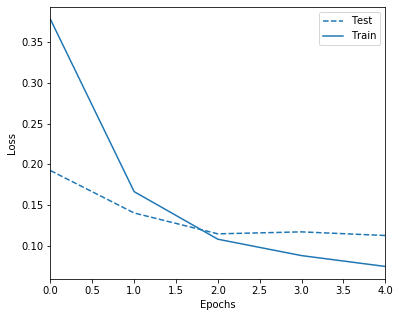

In [20]:
model_up.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_up.fit(up_X_train,
          pd.get_dummies(up_y_train),
          epochs=5,
          validation_data=(up_X_test, pd.get_dummies(up_y_test))
         )
plot_loss(history)
test_loss, test_acc = model_up.evaluate(up_X_test, pd.get_dummies(up_y_test))
print('Test accuracy:', test_acc)

In [23]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, up_X_test))
result['predict'] = model_up.predict_proba(up_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = up_y_test

전체채팅수11443, 유해채팅수5913


In [158]:
# result.to_csv('../../data/cnn_result.csv', encoding='utf-16')

## Downsampling

In [42]:
down_X, down_y = RandomUnderSampler().fit_resample(x_padded, datasets.label)
down_X_train, down_X_test, down_y_train, down_y_test = train_test_split(down_X, down_y)

# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(2228, 1114)

In [50]:
model_down = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

Train on 1671 samples, validate on 557 samples
Epoch 1/5
1671/1671 [==============================] - ETA: 1:16 - loss: 0.0717 - recall_10: 0.968 - ETA: 11s - loss: 0.0525 - recall_10: 0.974 - ETA: 5s - loss: 0.0585 - recall_10: 0.9714 - ETA: 3s - loss: 0.0554 - recall_10: 0.977 - ETA: 2s - loss: 0.0532 - recall_10: 0.981 - ETA: 1s - loss: 0.0583 - recall_10: 0.981 - ETA: 0s - loss: 0.0570 - recall_10: 0.981 - ETA: 0s - loss: 0.0669 - recall_10: 0.980 - ETA: 0s - loss: 0.0637 - recall_10: 0.980 - ETA: 0s - loss: 0.0694 - recall_10: 0.978 - 3s 2ms/sample - loss: 0.0684 - recall_10: 0.9791 - val_loss: 1.4497 - val_recall_10: 0.7253
Epoch 2/5
1671/1671 [==============================] - ETA: 0s - loss: 0.0664 - recall_10: 0.968 - ETA: 0s - loss: 0.1109 - recall_10: 0.968 - ETA: 0s - loss: 0.0777 - recall_10: 0.976 - ETA: 0s - loss: 0.0725 - recall_10: 0.977 - ETA: 0s - loss: 0.0749 - recall_10: 0.976 - ETA: 0s - loss: 0.0712 - recall_10: 0.977 - ETA: 0s - loss: 0.0885 - recall_10: 0.974 -

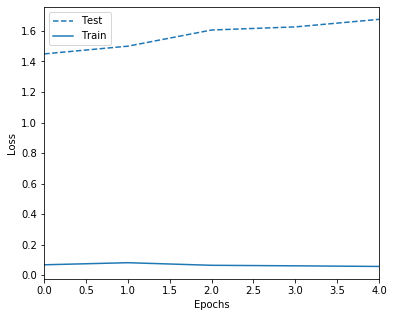

In [54]:
model_down.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_down.fit(down_X_train,
          pd.get_dummies(down_y_train),
          epochs=5,
          validation_data=(down_X_test, pd.get_dummies(down_y_test))
         )
plot_loss(history)
test_loss, test_acc = model_down.evaluate(down_X_test, pd.get_dummies(down_y_test))
print('Test Recall:', test_acc)

In [55]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, down_X_test))
result['predict'] = model_down.predict_proba(down_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = down_y_test

전체채팅수557, 유해채팅수280


In [27]:
# 예측 실패 채팅
result[model_up.predict_classes(up_X_test) != up_y_test]

,0,predict,label
6,<OOV> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <,0.434492,1
88,갑 분 싸다 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>,0.960686,0
126,ㅇㅈ <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD,0.534332,0
175,<OOV> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <,0.434492,1
244,<OOV> ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>,0.690133,0
250,시그마 장인 하다 <PAD> <PAD> <PAD> <PAD> <PAD> <PA,0.889551,0
254,<OOV> <OOV> <PAD> <PAD> <PAD> <PAD> <PAD> <,0.497842,1
300,미치다 ㅋㅋㅋ <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>,0.974296,0
370,ㄹㅇ <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD,0.484269,1
389,두 마리 미치다 같다 뒈 <PAD> <PAD> <PAD> <PAD> <PAD>,0.939132,0


In [24]:
test_chat = "시1123123123발"
test_id = text_to_index(morp.morphs(test_chat, norm=True,stem=True))

sentence_size = 10
x_padded_temp = sequence.pad_sequences([test_id],
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
print(morp.morphs(test_chat, norm=True,stem=True)[:10])
model_up.predict(x_padded_temp)

['시', '1123123123', '발']


array([[0.01354373, 0.9864073 ]], dtype=float32)

## 모델 체크포인트 저장

In [26]:
# model_up.save('../model/cnn_oversample.h5')

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용